In [139]:
import os
import torch

import torch.nn as nn
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
import seaborn as sns


from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import pdist, squareform


In [140]:
### load the dirs
base_dir = os.path.abspath('../..')
save_dir = os.path.join(base_dir,'results')
data_dir = os.path.join(base_dir,'data')
results_dir = os.path.join(base_dir,'results')

In [141]:
### specify the model
class TripletLabelModel(nn.Module):
    def __init__(self, encoded_space_dim=64, num_classes=4):
        super().__init__()
        ""
       ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
    
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        ## changed 32*4*4 to 32*2*2
        self.encoder_lin = nn.Sequential(
            nn.Linear(32*2*2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

        ## triplet projection module
        self.decoder_triplet_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True)
         
        )
        ##labeling module
        self.decoder_labels_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, num_classes),
        )

        ### initialize weights using xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x, y=None):
        batch_s = x.size(0)
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        
        enc_latent = self.encoder_lin(img_features)

        triplet_latent = self.decoder_triplet_lin(enc_latent)
        label = self.decoder_labels_lin(enc_latent)
        # label = F.softmax(label,dim=1)
        return enc_latent, label
    
### create instance of model
nn_model = TripletLabelModel()

In [142]:
### load in validation images and labels
v_ims = np.load(os.path.join(data_dir,'validation_set.npy')) ## validation images
v_labels = np.load(os.path.join(data_dir,'validation_labs.npy')) ### validation labels

## load in the trained model weights and store in a list
model_list = os.listdir(results_dir)
model_list = sorted(model_list)

In [143]:
model_list
### get all items in model_list that begin with 0
m = [i for i in model_list if i.startswith('0')]
m

['0_set_A2_label.pth',
 '0_set_A2_label_and_triplet.pth',
 '0_set_A2_triplet.pth',
 '0_set_A_label.pth',
 '0_set_A_label_and_triplet.pth',
 '0_set_A_triplet.pth',
 '0_set_B_label.pth',
 '0_set_B_label_and_triplet.pth',
 '0_set_B_triplet.pth',
 '0_set_C_label.pth',
 '0_set_C_label_and_triplet.pth',
 '0_set_C_triplet.pth']

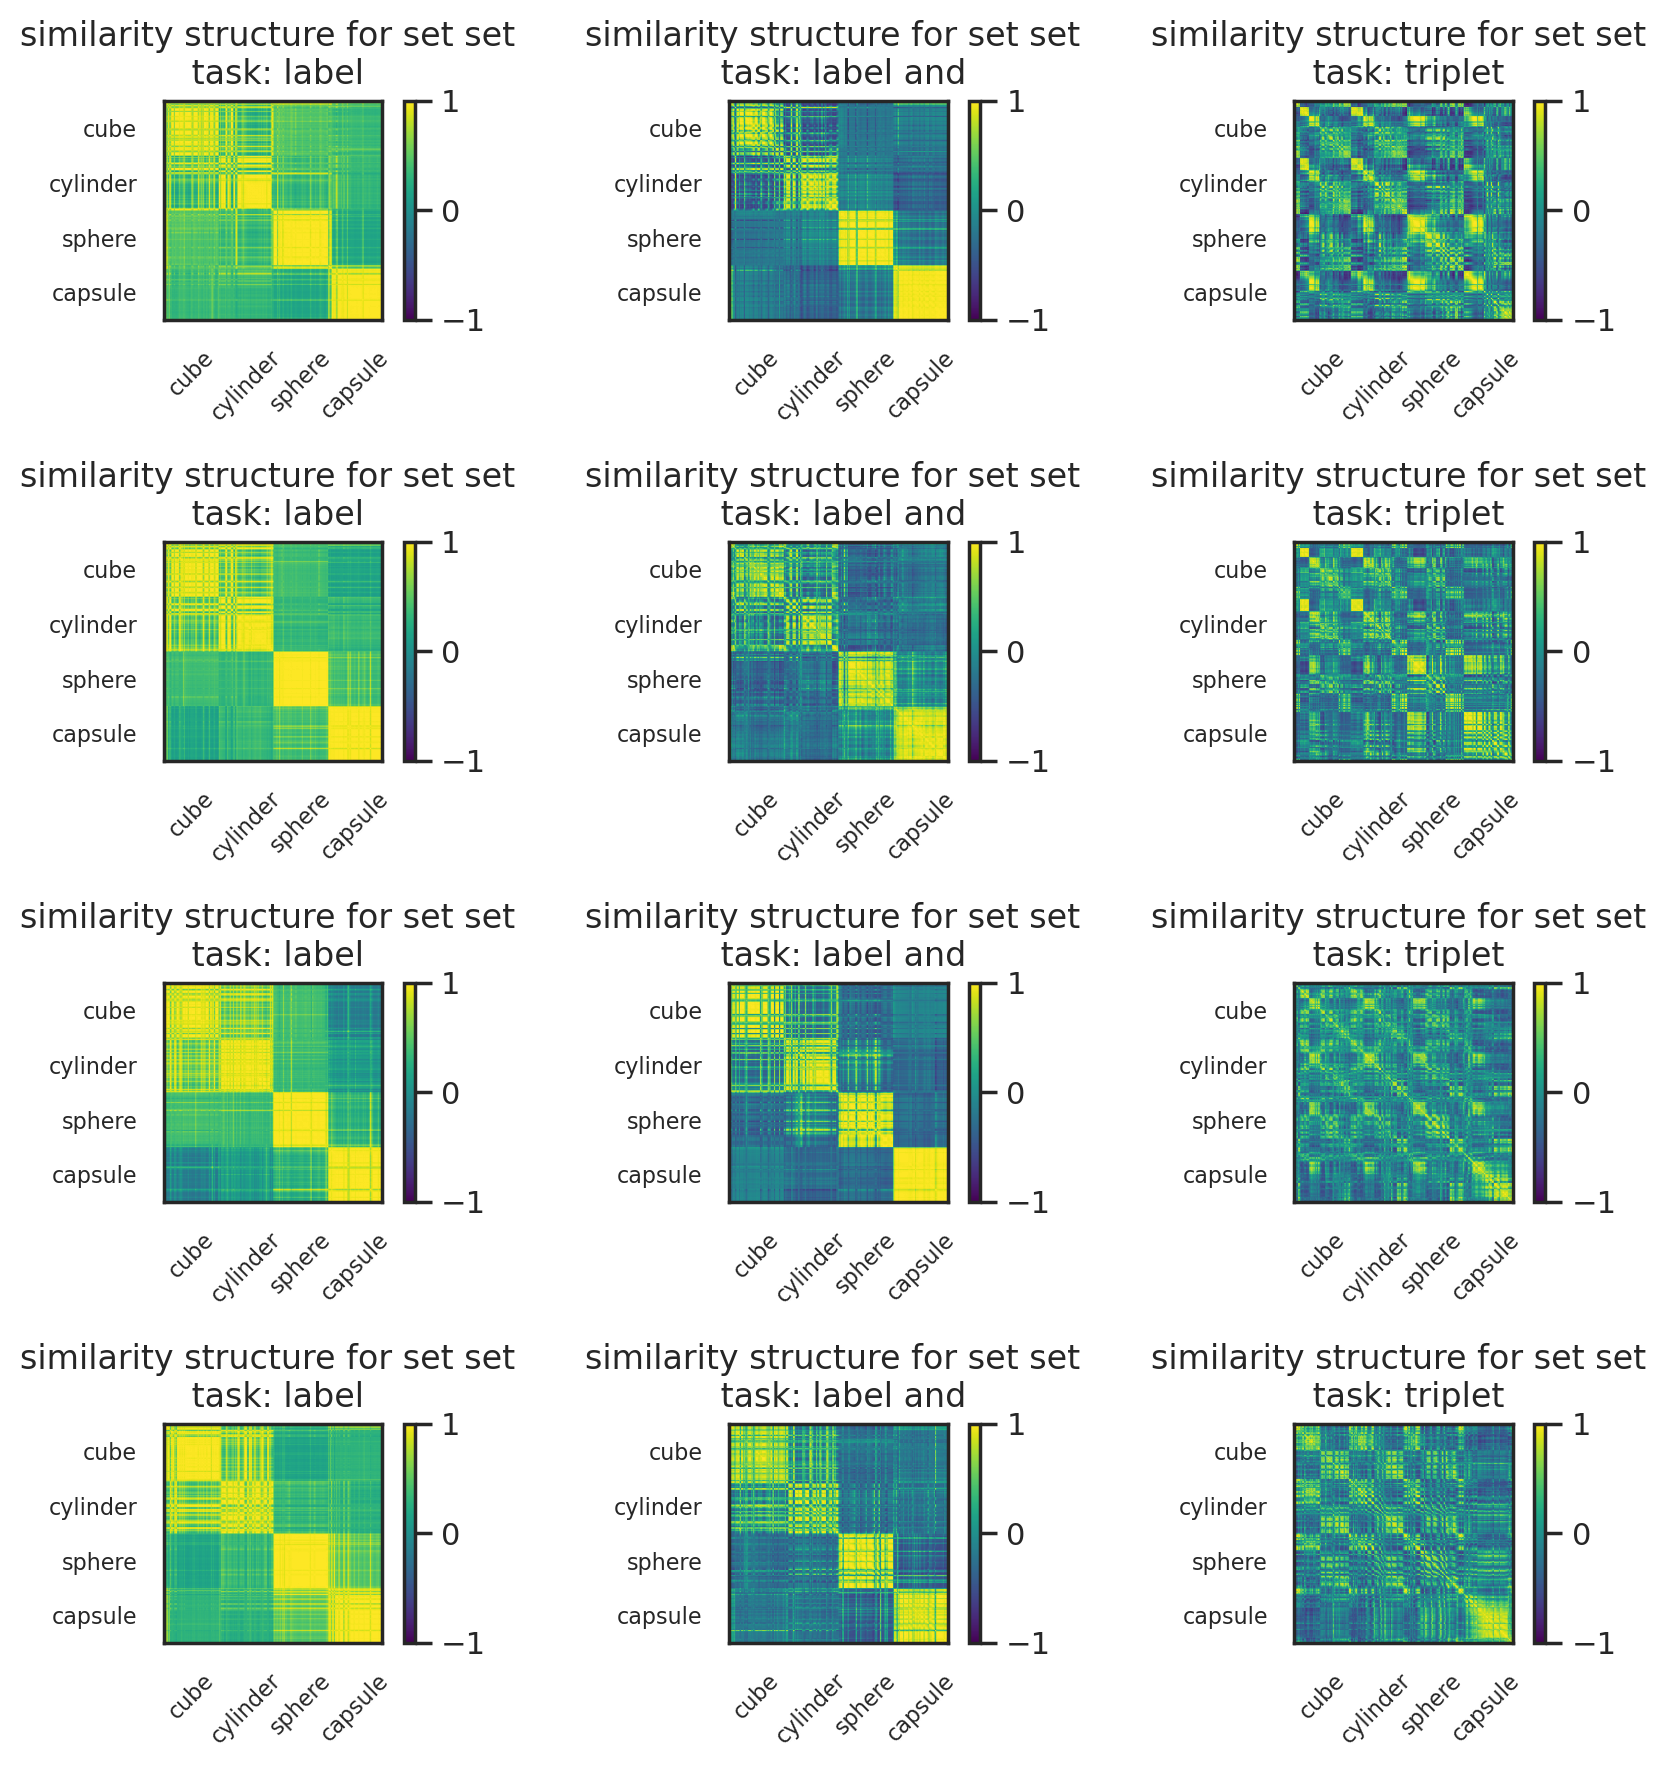

In [144]:
### load in each model and compute the accuracy on the validation set

nmodels= 10
accs = []
tasks = []
dsets = []
iters = []
latents_df =pd.DataFrame(columns=['dataset','task','latent','iter'])
fig, axes = plt.subplots(4,3,figsize=(9,9))

for iter in range(nmodels):
    m_sub = [k for k in model_list if k.startswith(str(iter))]
    for i, this_model in enumerate(m_sub):
        ax = axes.flatten()[i]
        nn_model.load_state_dict(torch.load(os.path.join(results_dir,this_model)))
        # nn_model.load_state_dict(torch.load(cifar_model))
        ### pass v_ims through the model but make sure to transpose the image dimensions first
        v_ims_t = torch.from_numpy(v_ims.transpose(0,3,1,2)).float()
        v_ims_t = v_ims_t/255.0
        v_ims_t = Resize(32)(v_ims_t)

        ### now pass v_ims through the model
        latents, labels = nn_model(v_ims_t)

        ### do an argmax on the labels to get the predicted labels
        pred_labels = torch.argmax(labels,dim=1)
        pred_labels = pred_labels.detach().numpy()

        correct = 0
        for j in range(len(pred_labels)):
            if pred_labels[j] == v_labels[j]:
                correct += 1
        # print(correct/len(pred_labels))
        accs.append(correct/len(pred_labels))
        tasks.append(this_model.split('_', 3)[3].rsplit('.', 1)[0])
        dsets.append(this_model.split("_")[2])
        iters.append(iter)


        # Compute pairwise cosine similarities
        cos_sim = cosine_similarity(latents.detach().numpy())

        # Plot heatmap
        im = ax.imshow(cos_sim, cmap='viridis', vmin=-1, vmax=1)
        cbar = ax.figure.colorbar(im, ax=ax,fraction=0.046, pad=0.04)
        cbar.set_ticks([-1,0,1])


        ax.set_xticks([60,180,300,420],['cube','cylinder','sphere','capsule'], rotation=45, fontsize=8)
        ax.set_yticks([60,180,300,420],['cube','cylinder','sphere','capsule'],fontsize=8)



        task_string = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        task_string = task_string.rsplit('_', 1)[0].replace('_', ' ')


    
        ax.set_title(f'similarity structure for set {this_model.split("_")[1]} \n task: {task_string}')
        fig.tight_layout()

        latents_df.loc[(nmodels*i)+iter,'dataset'] = this_model.split("_")[2]
        latents_df.loc[(nmodels*i)+iter,'task'] = this_model.split('_', 3)[3].rsplit('.', 1)[0]
        latents_df.loc[(nmodels*i)+iter,'latent'] = latents.detach().numpy()
        latents_df.loc[(nmodels*i)+iter,'iter'] = iter
        

    plt.show()
acc_df = pd.DataFrame({'task':tasks,'accuracy':accs,'dataset':dsets})



In [145]:
sns.set_theme(style="white")

In [146]:
acc_df.head()

,task,accuracy,dataset
0,label,0.875000,A2
1,label_and_triplet,0.916667,A2
2,triplet,0.191667,A2
3,label,0.922917,A
4,label_and_triplet,0.858333,A


(0.0, 1.0)

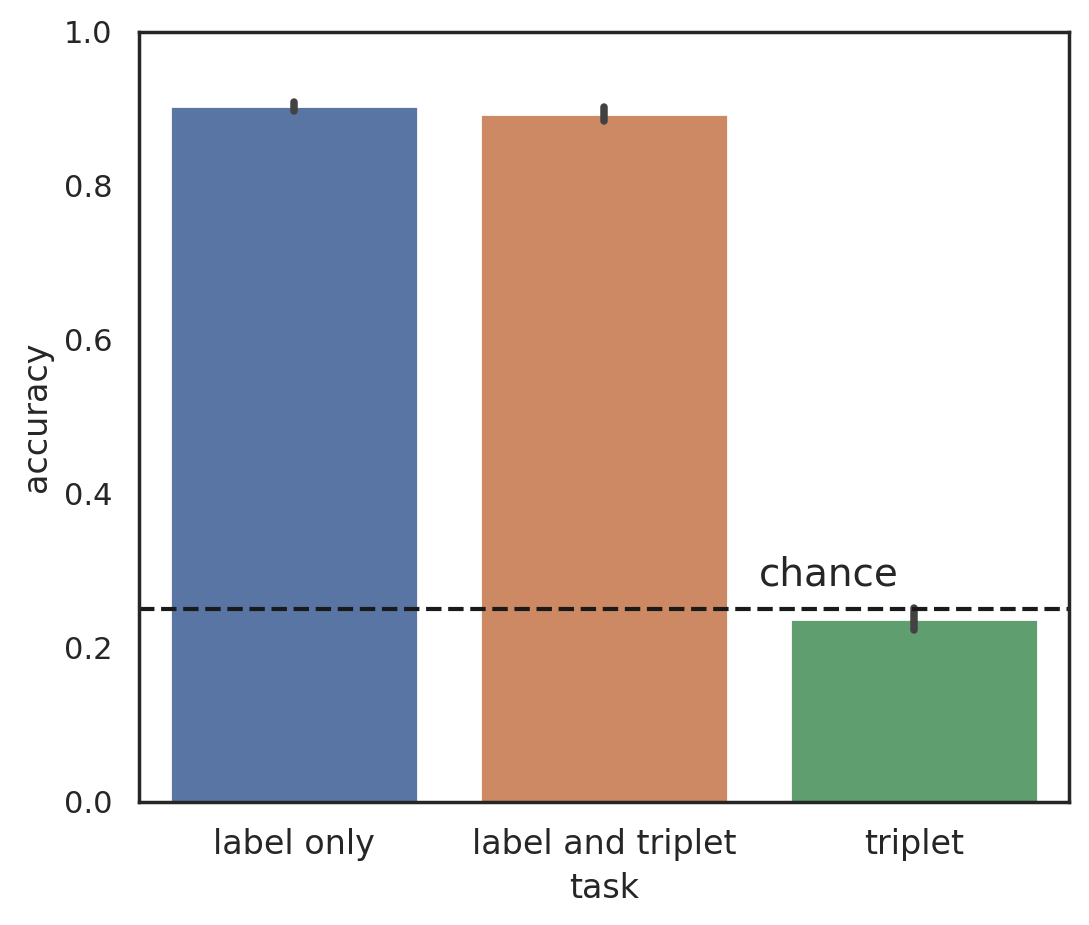

In [147]:
plt.figure(figsize=(6,5))
sns.barplot(x='task',y='accuracy',data=acc_df)
## add a horizontal line at 0.25 and annotate it with the word 'chance'
plt.axhline(0.25,ls='--',color='k')
plt.text(1.5,0.28,'chance',fontsize=14)

### set the x tick labels to be the task names
plt.xticks(range(3),['label only','label and triplet','triplet'],fontsize=12)
plt.ylim([0,1])


In [148]:
latents_df

,dataset,task,latent,iter
0,A2,label,"[[-0.2219373, 2.2494845, 0.78841823, 1.3341645...",0
10,A2,label_and_triplet,"[[-0.27834535, -0.28118953, 0.21440706, 0.1317...",0
20,A2,triplet,"[[-2.346183, -0.20968872, 0.7601119, 1.1399821...",0
30,A,label,"[[1.841282, 1.440677, 0.45024624, 0.41042116, ...",0
40,A,label_and_triplet,"[[1.4040735, 0.25026938, 0.10856034, 0.1502518...",0
...,...,...,...,...
79,B,label_and_triplet,"[[0.5706371, 0.7276867, -0.09106099, -0.022883...",9
89,B,triplet,"[[1.6877229, -2.5214434, 0.7848092, -0.1197739...",9
99,C,label,"[[0.26072448, 0.2508362, 1.5580437, 0.11557171...",9
109,C,label_and_triplet,"[[-0.9788434, 1.1313938, 0.2750972, 0.83509696...",9


In [149]:
dss.latent[29].shape
480%120

0

In [150]:
# latents_df = latents_df[latents_df['task']!='label']
latents_df.head()
# dss.latents


def compute_within_between_procrustes(mat1,mat2, items_per_cat=120):
    within_procrustes = []
    between_procrustes = []
    assert mat1.shape == mat2.shape
    for i in range(int(mat1.shape[0]/items_per_cat)):
        # print('i',i)
        mat1_sub = mat1[i*items_per_cat:(i+1)*items_per_cat,:]
    
        mat2_sub = mat2[i*items_per_cat:(i+1)*items_per_cat,:]
        ### get all the rows in mat2 not in mat2_sub using array indexing

        mat2_sub_c = mat2[np.isin(mat2[:,0],mat2_sub[:,0],invert=True),:]

    
        within_procrustes.append(procrustes(mat1_sub,mat2_sub)[2])
        # print('mat_sub_c shape',mat2_sub_c.shape[0])
        for j in range(int(mat2_sub_c.shape[0]/items_per_cat)):
            # print('j',j)
            this_sub_mat2 = mat2_sub_c[j*items_per_cat:(j+1)*items_per_cat,:]
    
            between_procrustes.append(procrustes(mat1_sub,this_sub_mat2)[2])
            
            # print(procrustes(mat1_sub,this_sub_mat2)[2])
    mean_w_procrustes = np.mean(within_procrustes)
    mean_b_procrustes = np.mean(between_procrustes)
   
    return mean_w_procrustes, mean_b_procrustes
            
    

(480, 480)

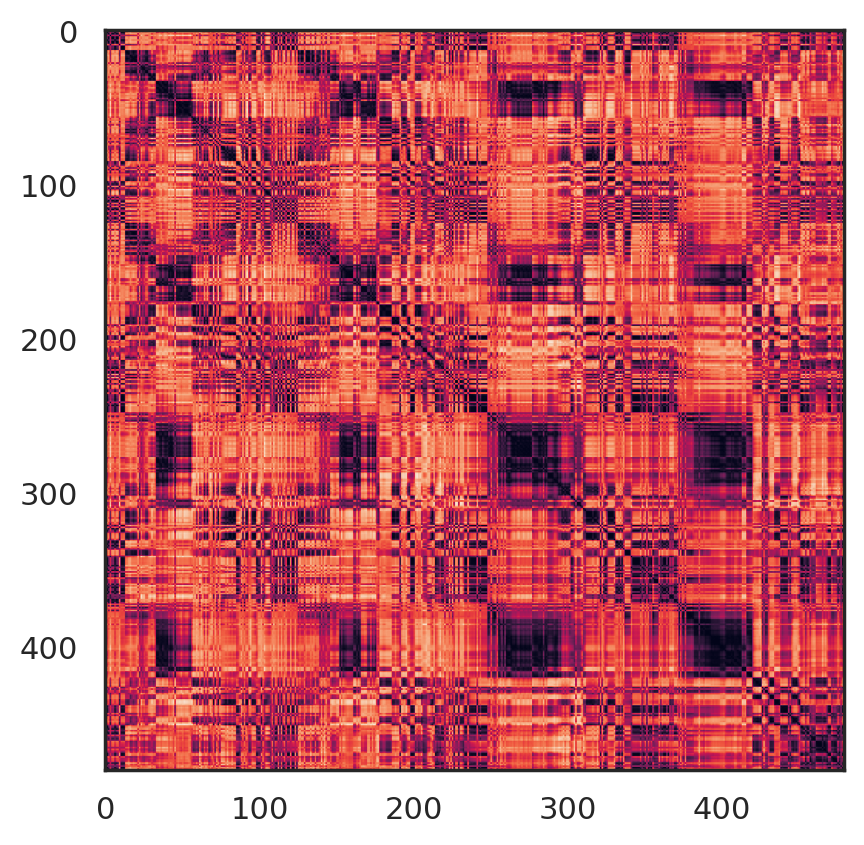

In [151]:
plt.imshow(squareform(distA))
squareform(distA).shape

In [152]:

from scipy.spatial import procrustes

tasks=[]
overlaps = []
withins = []
betweens = []
proc_withins = []
proc_betweens = []
procruses = []
cat_scores_1 = []
cat_scores_2 = []
iters = []
m1s = []
m2s = []
for this_task in latents_df['task'].unique():
   ds = latents_df[latents_df['task']==this_task]
   for this_iter in ds['iter'].unique():
      dss = ds[ds['iter']==this_iter]
      distA = pdist(dss[dss.dataset=='A']['latent'].values[0], metric='cosine')
      distA2 = pdist(dss[dss.dataset=='A2']['latent'].values[0], metric='cosine')
      distB = pdist(dss[dss.dataset=='B']['latent'].values[0], metric='cosine')
      distC = pdist(dss[dss.dataset=='C']['latent'].values[0], metric='cosine')

      blocksize = 120
      block_diag = np.zeros((480,480))
      for i in range(4):
         block_diag[i*blocksize:(i+1)*blocksize,i*blocksize:(i+1)*blocksize] = 1

      ### mask distA with block_diag
      within_distA = squareform(distA)*block_diag
      between_distA = squareform(distA)*(1-block_diag)
      within_distA2 = squareform(distA2)*block_diag
      between_distA2 = squareform(distA2)*(1-block_diag)
      within_distB = squareform(distB)*block_diag
      between_distB = squareform(distB)*(1-block_diag)
      within_distC = squareform(distC)*block_diag
      between_distC = squareform(distC)*(1-block_diag)

      ### compute categoricality measures

      categoricality_A = np.mean(between_distA)/np.mean(within_distA)
      categoricality_A2 = np.mean(between_distA2)/np.mean(within_distA2)
      categoricality_B = np.mean(between_distB)/np.mean(within_distB)
      categoricality_C = np.mean(between_distC)/ np.mean(within_distC)





      ### compute distance matrices and get lower triangles
      dmatA_within = np.tril(within_distA,k=-1).flatten()
      dmatA2_within = np.tril(within_distA2,k=-1).flatten()
      dmatB_within = np.tril(within_distB,k=-1).flatten()
      dmatC_within = np.tril(within_distC,k=-1).flatten()
   

      dmatA_between = np.tril(between_distA,k=-1).flatten()
      dmatA2_between = np.tril(between_distA2,k=-1).flatten()
      dmatB_between = np.tril(between_distB,k=-1).flatten()
      dmatC_between = np.tril(between_distC,k=-1).flatten()


      # AB_sim = np.corrcoef(dmatA,dmatB)[0,1]
      # AC_sim = np.corrcoef(dmatA,dmatC)[0,1]
      # BC_sim = np.corrcoef(dmatB,dmatC)[0,1]
      # AB_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='B']['latent'].values[0] )[2]
      # AC_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )[2]
      # BC_proc = procrustes(dss[dss.dataset=='B']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )[2]
      # AA_proc = procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='A2']['latent'].values[0] )[2]

      AB_proc = procrustes(squareform(distA), squareform(distB) )[2]
      AC_proc = procrustes(squareform(distA), squareform(distC) )[2]
      BC_proc = procrustes(squareform(distB), squareform(distC) )[2]
      AA_proc = procrustes(squareform(distA), squareform(distA2) )[2]

      # AB_proc_within,  AB_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='B']['latent'].values[0] )
      # AC_proc_within,  AC_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )
      # BC_proc_within,  BC_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='B']['latent'].values[0], dss[dss.dataset=='C']['latent'].values[0] )
      # AA_proc_within,  AA_proc_between  = compute_within_between_procrustes(dss[dss.dataset=='A']['latent'].values[0], dss[dss.dataset=='A2']['latent'].values[0] )

      AB_proc_within,  AB_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distB) )
      AC_proc_within,  AC_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distC) )
      BC_proc_within,  BC_proc_between  = compute_within_between_procrustes(squareform(distB), squareform(distC) )
      AA_proc_within,  AA_proc_between  = compute_within_between_procrustes(squareform(distA), squareform(distA2) )
      

   


      AB_within_sim = np.corrcoef(dmatA_within,dmatB_within)[0,1]
      AC_within_sim = np.corrcoef(dmatA_within,dmatC_within)[0,1]
      BC_within_sim = np.corrcoef(dmatB_within,dmatC_within)[0,1]
      AA_within_sim = np.corrcoef(dmatA_within,dmatA2_within)[0,1]

      AB_between_sim = np.corrcoef(dmatA_between,dmatB_between)[0,1]
      AC_between_sim = np.corrcoef(dmatA_between,dmatC_between)[0,1]
      BC_between_sim = np.corrcoef(dmatB_between,dmatC_between)[0,1]
      AA_between_sim = np.corrcoef(dmatA_between,dmatA2_between)[0,1]

      # print(f'{this_task} results')
      # print(f'AA within category similarity for {this_task} is {AA_within_sim}')
      # print(f'AB within category similarity for {this_task} is {AB_within_sim}')
      # print(f'AC within category similarity for {this_task} is {AC_within_sim}')
      # print(f'BC within category similarity for {this_task} is {BC_within_sim}')
      # print('')
      # print(f'AA between category similarity for {this_task} is {AA_between_sim}')
      # print(f'AB between category similarity for {this_task} is {AB_between_sim}')
      # print(f'AC between category similarity for {this_task} is {AC_between_sim}')
      # print(f'BC between category similarity for {this_task} is {BC_between_sim}')
      # print('')
      tasks.append([this_task]*4)
      overlaps.append([50,0,33.33,100])
      withins.append([AB_within_sim,AC_within_sim,BC_within_sim,AA_within_sim])
      betweens.append([AB_between_sim,AC_between_sim,BC_between_sim,AA_between_sim])
      procruses.append([AB_proc,AC_proc,BC_proc,AA_proc])
      proc_withins.append([AB_proc_within,AC_proc_within,BC_proc_within,AA_proc_within])
      proc_betweens.append([AB_proc_between,AC_proc_between,BC_proc_between,AA_proc_between])
      cat_scores_1.append([categoricality_A,categoricality_A,categoricality_B,categoricality_A])
      cat_scores_2.append([categoricality_B,categoricality_C,categoricality_C,categoricality_A2])
      iters.append([this_iter]*4)
      # m1s.append()






In [153]:
sim_df = pd.DataFrame({'task':np.array(tasks).flatten(), 'overlap':np.array(overlaps).flatten(),\
                       'within':np.array(withins).flatten(),'between':np.array(betweens).flatten(), \
                        'procrustes':np.array(procruses).flatten(), 'proc_within':np.array(proc_withins).flatten(),\
                         'proc_between':np.array(proc_betweens).flatten(),'cat_score_1':np.array(cat_scores_1).flatten(),\
                             'cat_score_2':np.array(cat_scores_2).flatten(),'iter':np.array(iters).flatten() })
sim_df['mean_cat_score'] = (sim_df['cat_score_1'] + sim_df['cat_score_2'])/2    
sim_df['procrustes_sim'] = 1/(sim_df['procrustes'])


In [154]:
sim_df

,task,overlap,within,between,procrustes,proc_within,proc_between,cat_score_1,cat_score_2,iter,mean_cat_score,procrustes_sim
0,label,50.00,0.481225,0.935343,0.191462,0.807533,0.980445,23.240521,26.782728,0,25.011625,5.222973
1,label,0.00,0.417167,0.915985,0.306336,0.853869,0.956442,23.240521,19.617986,0,21.429253,3.264394
2,label,33.33,0.468864,0.876330,0.341232,0.903387,0.980554,26.782728,19.617986,0,23.200357,2.930561
3,label,100.00,0.736411,0.921413,0.285270,0.691429,0.977836,23.240521,14.233328,0,18.736924,3.505448
4,label,50.00,0.536331,0.903133,0.300994,0.768796,0.965277,14.960759,21.146188,1,18.053474,3.322331
...,...,...,...,...,...,...,...,...,...,...,...,...
115,triplet,100.00,0.934764,0.924164,0.381984,0.360206,0.833219,3.403720,3.435868,8,3.419794,2.617911
116,triplet,50.00,0.841132,0.831383,0.768113,0.714821,0.861174,3.332493,3.312654,9,3.322573,1.301891
117,triplet,0.00,0.800308,0.803164,0.890236,0.830791,0.847006,3.332493,3.936625,9,3.634559,1.123298
118,triplet,33.33,0.804749,0.799841,0.867844,0.840896,0.870398,3.312654,3.936625,9,3.624639,1.152280


Text(125.42671875000002, 0.5, 'procrustes disparity')

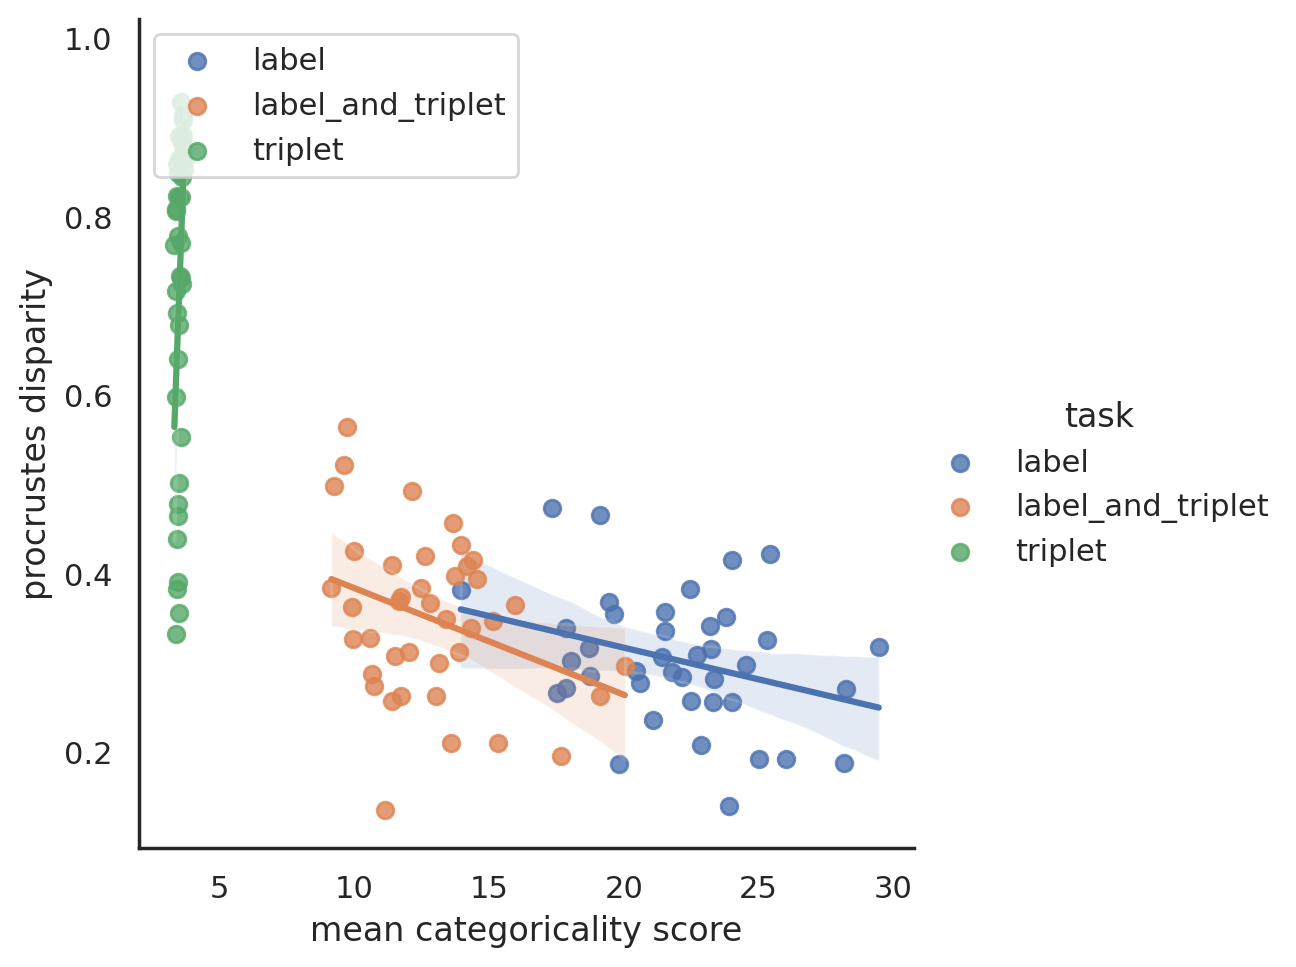

In [155]:
sns.lmplot(x='mean_cat_score',y='procrustes',data=sim_df, hue='task',fit_reg=True,legend=True)
plt.legend(loc='upper left')
plt.xlabel('mean categoricality score')
plt.ylabel('procrustes disparity')

Text(0.5, 0, 'task')

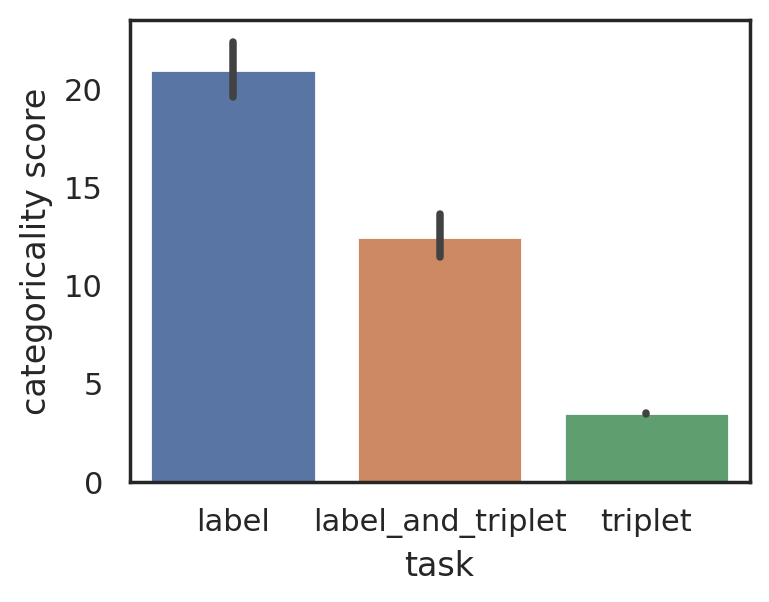

In [156]:
from scipy.stats import pearsonr
plt.figure(figsize=(4,3))
sns.barplot(x='task',y='cat_score_1',data=sim_df)
plt.ylabel('categoricality score')
plt.xlabel('task')


In [157]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

cat_model = ols('procrustes ~ cat_score_2', data=sim_df).fit()

anova_table = sm.stats.anova_lm(cat_model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
cat_score_2,3.289881,1.0,141.137553,6.867436e-22
Residual,2.750551,118.0,NaN,NaN


In [158]:

sim_df = pd.melt(sim_df, id_vars=['task','overlap'], value_vars=['within','between','procrustes'])

sim_df.columns = ['task','overlap','dist_type','alignment']
sim_df

,task,overlap,dist_type,alignment
0,label,50.00,within,0.481225
1,label,0.00,within,0.417167
2,label,33.33,within,0.468864
3,label,100.00,within,0.736411
4,label,50.00,within,0.536331
...,...,...,...,...
355,triplet,100.00,procrustes,0.381984
356,triplet,50.00,procrustes,0.768113
357,triplet,0.00,procrustes,0.890236
358,triplet,33.33,procrustes,0.867844


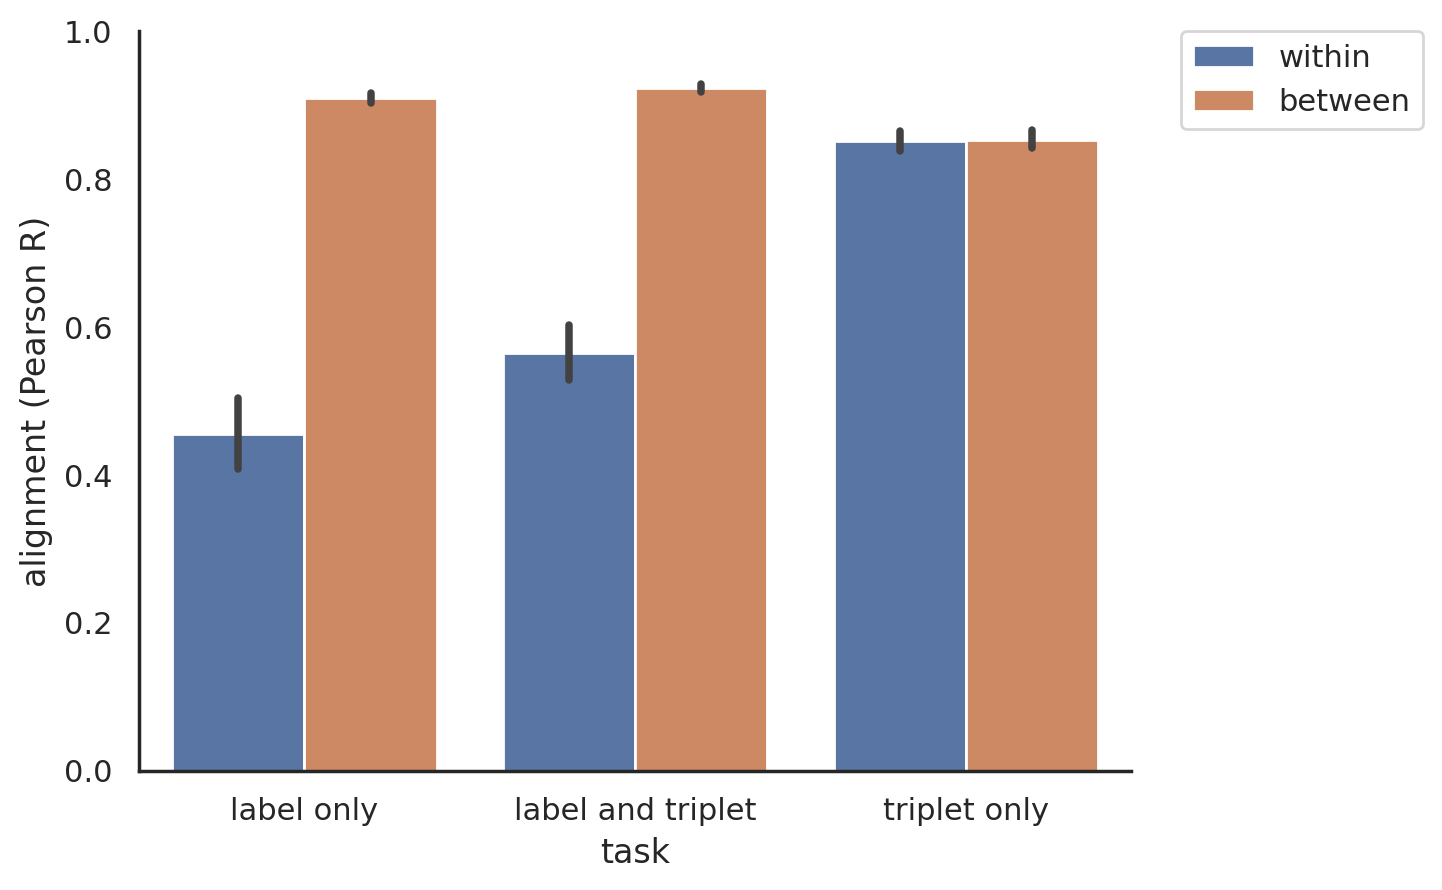

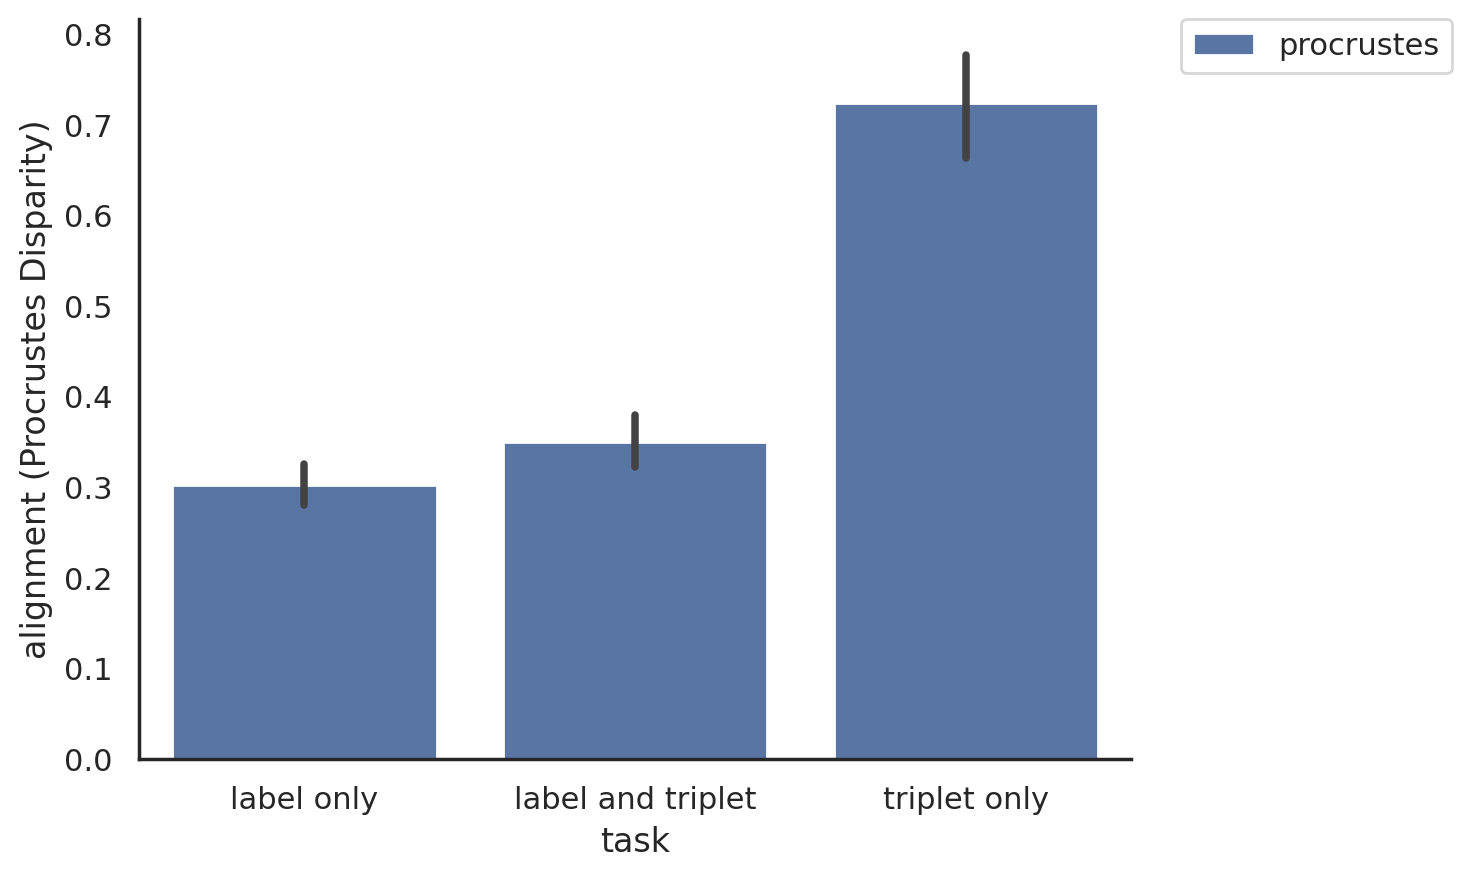

In [159]:

sns.set_theme(style="white")
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['within','between' ], data=sim_df)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Pearson R)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
plt.ylim([0,1])
plt.show()
sns.barplot(x="task", y="alignment", hue="dist_type", hue_order=['procrustes'], data=sim_df)
sns.despine()
### move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('alignment (Procrustes Disparity)')
plt.xticks([0,1,2],['label only','label and triplet', 'triplet only'])
# plt.ylim([0,1])
plt.show()

/mnt/ws/home/kmukherjee/miniconda3/envs/sketch_tools/lib/python3.8/site-packages/seaborn/axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


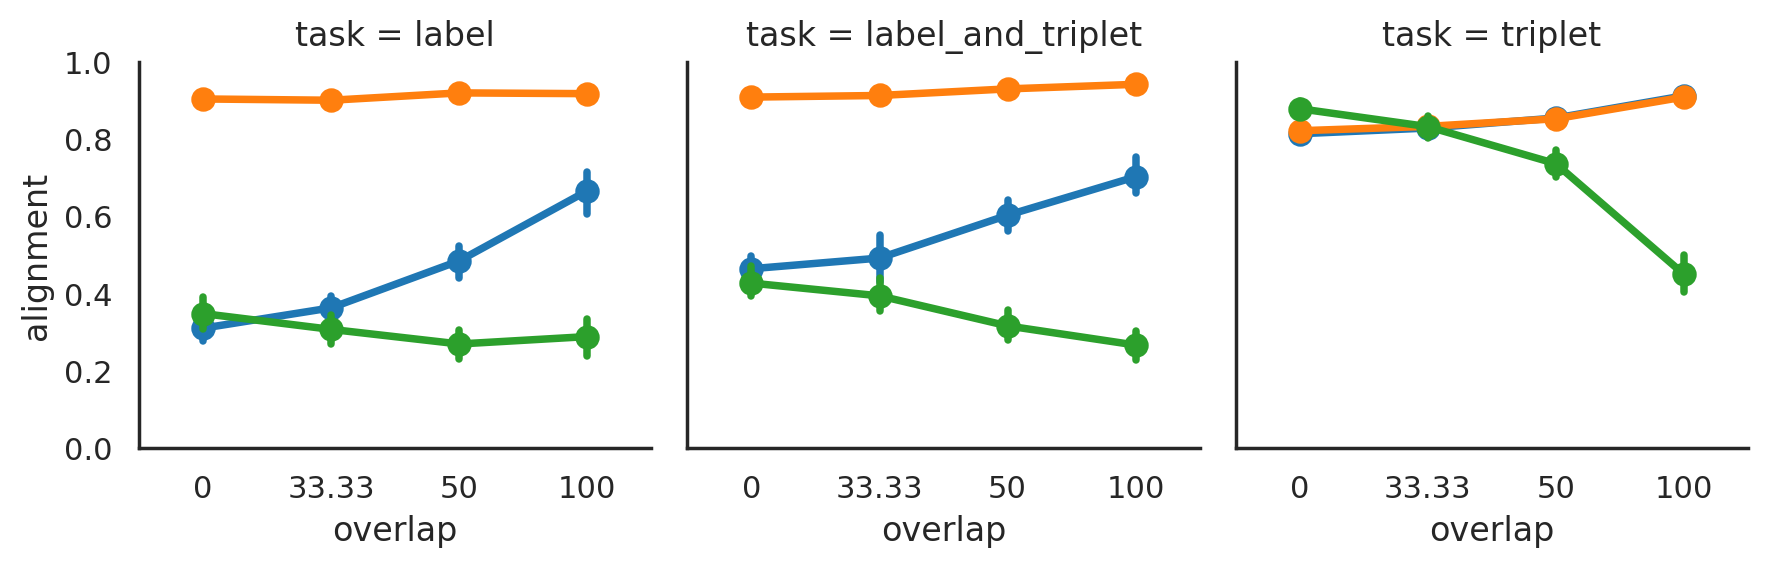

In [160]:
sns.set_theme(style="white")
# sns.pointplot(x="overlap", y="similarity", hue='category', data=sim_df)
# plt.ylim([0,1])
g = sns.FacetGrid(sim_df,  col="task", margin_titles=True)
g.map(sns.pointplot, "overlap", "alignment", "dist_type", order=[0,33.33,50,100],palette='tab10')
g.set(ylim=(0, 1))
